In [2]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
import getpass
import importlib
from tqdm import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')


## Estimate 12x12

In [3]:
glm = 1
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,102,103,104,106,107,108,109,110,111,112,113,114,115]
hem = ['L','R']
atlas,_ = am.get_atlas('fs32k')

# Intrinsic ordering of the conditions:
rdm_cols = ['lhand:0','lhand:60','lhand:120','lhand:180','lhand:240','lhand:300',
            'rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240'] 
G_matrices = {}
D_matrices = {}
for sn in sn_list:
    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
    partitions = regressor_info['run'].values.flatten()
    conds = regressor_info['name'].values.flatten()
    conds = np.array([cond.strip() for cond in np.array(conds)])
    
    for j, h in enumerate(hem):
        # ==========================================
        # DATA EXTRACTION
        # ==========================================
        #  Define atlas map
        white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
        pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
        mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

        # File names for data extraction
        nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', "beta_*.nii")))
        nii_names = nii_names[0:480] # remove the run constant regressors
        resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii')]
        
        beta = []
        resMS = []
        beta_white = []
        for i, r in enumerate(region_labels):
            atlas_tmp = atlas.get_hemisphere(j)
            subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
            amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
            # Compute the voxels in native space
            amap.build()
            
            # This extract all the relevant voxels in native space (use for RSA)
            beta = amap.extract_data_native(nii_names)
            idx_nan = np.isnan(beta).any(axis=0)
            beta = beta[:, ~idx_nan]
            resMS = amap.extract_data_native(resMS_name)
            resMS = resMS[:, ~idx_nan]
            beta_white = beta/np.sqrt(resMS)
            
            # ========================================== 
            # Estimated variance-covariance matrix
            # ==========================================
            # select unimanual conditions:
            idx = [('lhand' in tmp or 'rhand' in tmp) for tmp in conds]
            Y = beta_white[idx,:]
            cond_vec = conds[idx]
            partition_vec = partitions[idx]
            Z = utils.please.indicator(cond_vec, rdm_cols)
            G_hat,_ = pcm.est_G_crossval(Y,
                                         Z,
                                         partition_vec,
                                         X=pcm.matrix.indicator(partition_vec))
            D = np.sign(pcm.G_to_dist(G_hat)) * np.sqrt(np.abs(pcm.G_to_dist(G_hat)))
            
            key = (sn, h, region_names[i])
            G_matrices[key] = G_hat
            D_matrices[key] = D

# Construct the long DataFrame
rows = []
for key in G_matrices:
    sn, hem, region = key
    G = G_matrices[key]
    D = D_matrices[key]

    row = {'sn': sn, 'hem': hem, 'region': region}
    row.update(utils.please.flatten_matrix(G, rdm_cols, 'G'))
    row.update(utils.please.flatten_matrix(D, rdm_cols, 'D'))
    rows.append(row)

ana = pd.DataFrame(rows)
ana.to_csv(os.path.join(analysisDir,'G_uni.csv'), index=False)
ana.to_feather(os.path.join(analysisDir,'G_uni.feather'))



### PLOT G MATRIX

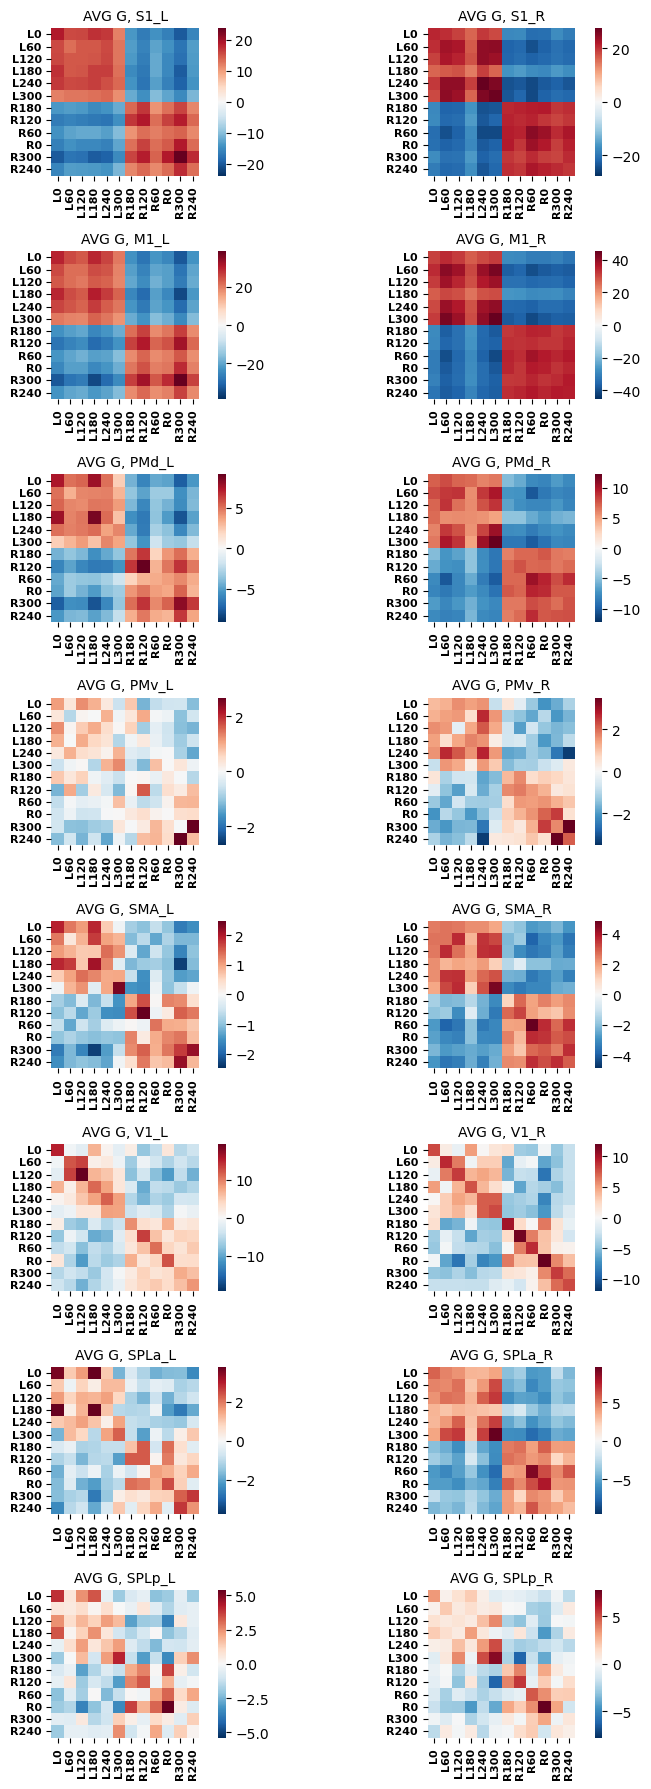

In [5]:
ana = pd.read_feather(os.path.join(analysisDir,'G_uni.feather'))

rdm_cols = ['lhand:0','lhand:60','lhand:120','lhand:180','lhand:240','lhand:300',
            'rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240'] 
labels = ['L0','L60','L120','L180','L240','L300',
          'R180','R120','R60','R0','R300','R240']
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

sn_list = ana.sn.unique()
hem = ana.hem.unique()
regions = ana.region.unique()

cmap = matplotlib.cm.RdBu.reversed()
G_avg = np.zeros((len(hem),len(regions), len(rdm_cols), len(rdm_cols)))
n_cond = len(rdm_cols)
for sn in sn_list:
    fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8,18))
    for j, h in enumerate(hem):
        for i, ax in enumerate(axes[:,j].flat):
            row = ana[(ana.sn==sn) & (ana.hem==h) & (ana.region==region_names[i])]
            G_hat = utils.please.retrieve_matrix(row, prefix='G', colnames=rdm_cols)
            v_max = np.max(G_hat)
            v_min = np.min(G_hat)
            v_max = max(abs(v_max), abs(v_min))
            sns.heatmap(G_hat, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
            ax.set_title(f'G, {region_names[i]}_{h}, s{sn}', fontsize=10)

            # Set labels manually with more formatting options
            ax.set_xticks(np.arange(0,n_cond)+0.5)
            ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
            ax.set_yticks(np.arange(0,n_cond)+0.5)
            ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')

            # avg RDMs:
            G_avg[j,i,:,:] = G_avg[j,i,:,:] + G_hat/len(sn_list)
        
    plt.tight_layout()
    plt.savefig(f'../figures/G_uni/s{sn}_G_uni.pdf', bbox_inches="tight")
    plt.close()

# AVG G PLOT:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8,18))
for j, h in enumerate(hem):
    for i, ax in enumerate(axes[:,j].flat):
        G_hat = G_avg[j,i,:,:]
        v_max = np.max(G_hat)
        v_min = np.min(G_hat)
        v_max = max(abs(v_max), abs(v_min))
        sns.heatmap(G_hat, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
        ax.set_title(f'AVG G, {region_names[i]}_{h}', fontsize=10)
        
        # Set labels manually with more formatting options
        ax.set_xticks(np.arange(0,n_cond)+0.5)
        ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
        ax.set_yticks(np.arange(0,n_cond)+0.5)
        ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/G_uni/G_avg.pdf', bbox_inches="tight")
plt.show()



### PLOT D MATRIX

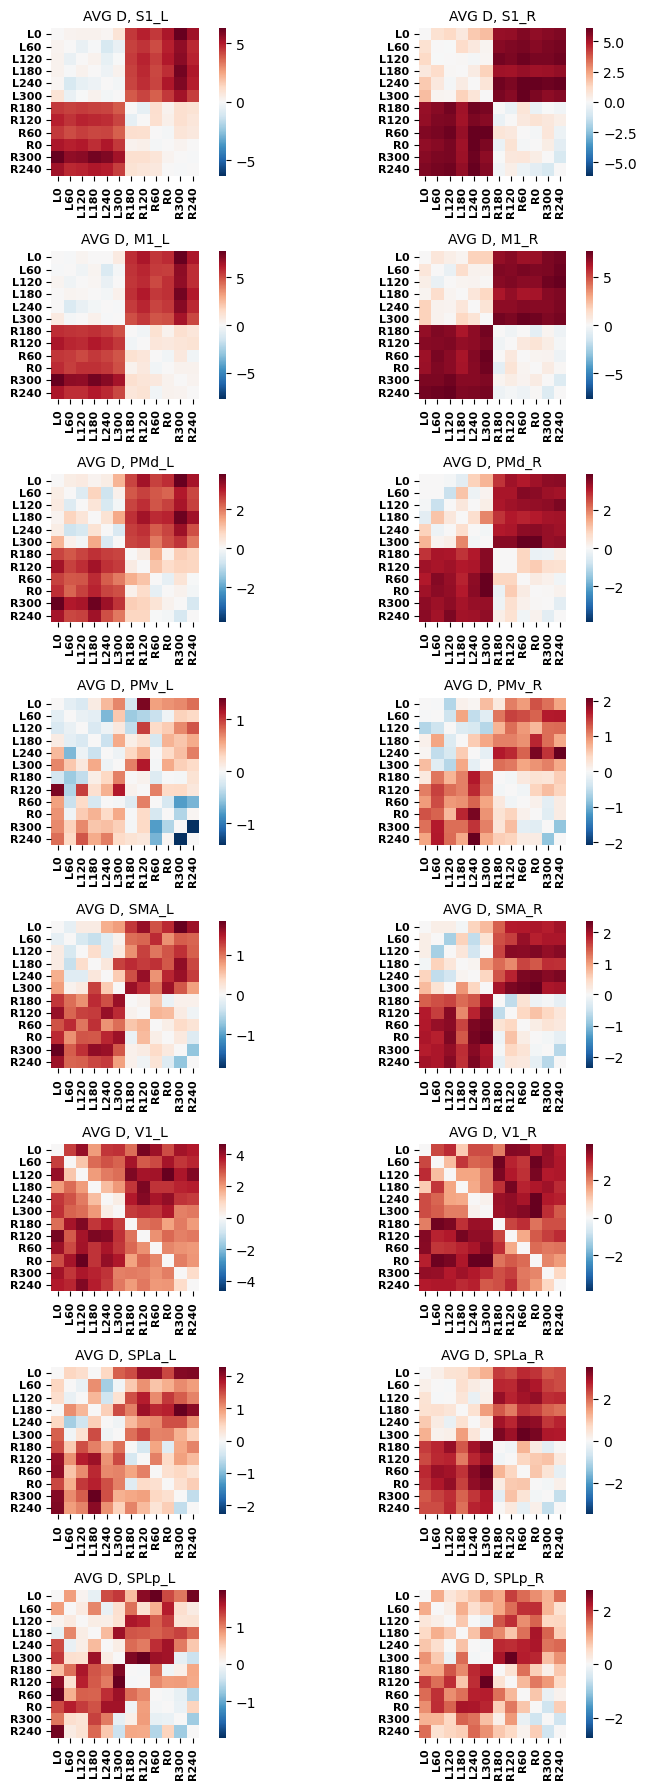

In [6]:
ana = pd.read_feather(os.path.join(analysisDir,'G_uni.feather'))

rdm_cols = ['lhand:0','lhand:60','lhand:120','lhand:180','lhand:240','lhand:300',
            'rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240'] 
labels = ['L0','L60','L120','L180','L240','L300',
          'R180','R120','R60','R0','R300','R240']
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

sn_list = ana.sn.unique()
hem = ana.hem.unique()
regions = ana.region.unique()

D_avg = np.zeros((len(hem),len(regions), len(rdm_cols), len(rdm_cols)))
n_cond = len(rdm_cols)
cmap = matplotlib.cm.RdBu.reversed()
for sn in sn_list:
    fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8,18))
    for j, h in enumerate(hem):
        for i, ax in enumerate(axes[:,j].flat):
            row = ana[(ana.sn==sn) & (ana.hem==h) & (ana.region==region_names[i])]
            D = utils.please.retrieve_matrix(row, prefix='D', colnames=rdm_cols)
            v_max = np.max(D)
            v_min = np.min(D)
            v_max = max(abs(v_max), abs(v_min))
            
            # cmap_reversed = cmap.reversed()
            sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
            ax.set_title(f'D, {region_names[i]}_{h}, s{sn}', fontsize=10)

            # Set labels manually with more formatting options
            ax.set_xticks(np.arange(0,n_cond)+0.5)
            ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
            ax.set_yticks(np.arange(0,n_cond)+0.5)
            ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')

            # avg RDMs:
            D_avg[j,i,:,:] = D_avg[j,i,:,:] + D/len(sn_list)
        
    plt.tight_layout()
    plt.savefig(f'../figures/D_uni/s{sn}_D_uni.pdf', bbox_inches="tight")
    plt.close()

# AVG D PLOT:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8,18))
for j, h in enumerate(hem):
    for i, ax in enumerate(axes[:,j].flat):
        D = D_avg[j,i,:,:]
        v_max = np.max(D)
        v_min = np.min(D)
        v_max = max(abs(v_max), abs(v_min))
        sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
        ax.set_title(f'AVG D, {region_names[i]}_{h}', fontsize=10)
        
        # Set labels manually with more formatting options
        ax.set_xticks(np.arange(0,n_cond)+0.5)
        ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
        ax.set_yticks(np.arange(0,n_cond)+0.5)
        ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/D_uni/D_avg.pdf', bbox_inches="tight")
plt.show()



## Estimate only right hand 6x6

In [10]:
glm = 1
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,102,103,104,106,107,108,109,110,111,112,113,114,115]
hem = ['L','R']
atlas,_ = am.get_atlas('fs32k')

# Intrinsic ordering of the conditions:
rdm_cols = ['rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240'] 
G_matrices = {}
D_matrices = {}
for sn in sn_list:
    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
    partitions = regressor_info['run'].values.flatten()
    conds = regressor_info['name'].values.flatten()
    conds = np.array([cond.strip() for cond in np.array(conds)])
    
    for j, h in enumerate(hem):
        # ==========================================
        # DATA EXTRACTION
        # ==========================================
        #  Define atlas map
        white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
        pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
        mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

        # File names for data extraction
        nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', "beta_*.nii")))
        nii_names = nii_names[0:480] # remove the run constant regressors
        resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii')]
        
        beta = []
        resMS = []
        beta_white = []
        for i, r in enumerate(region_labels):
            atlas_tmp = atlas.get_hemisphere(j)
            subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
            amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
            # Compute the voxels in native space
            amap.build()
            
            # This extract all the relevant voxels in native space (use for RSA)
            beta = amap.extract_data_native(nii_names)
            idx_nan = np.isnan(beta).any(axis=0)
            beta = beta[:, ~idx_nan]
            resMS = amap.extract_data_native(resMS_name)
            resMS = resMS[:, ~idx_nan]
            beta_white = beta/np.sqrt(resMS)
            
            # ========================================== 
            # Estimated variance-covariance matrix
            # ==========================================
            # select unimanual conditions:
            idx = [tmp in rdm_cols for tmp in conds]
            Y = beta_white[idx,:]
            cond_vec = conds[idx]
            partition_vec = partitions[idx]
            Z = utils.please.indicator(cond_vec, rdm_cols)
            G_hat,_ = pcm.est_G_crossval(Y,
                                         Z,
                                         partition_vec,
                                         X=pcm.matrix.indicator(partition_vec))
            D = np.sign(pcm.G_to_dist(G_hat)) * np.sqrt(np.abs(pcm.G_to_dist(G_hat)))
            
            key = (sn, h, region_names[i])
            G_matrices[key] = G_hat
            D_matrices[key] = D

# Construct the long DataFrame
rows = []
for key in G_matrices:
    sn, hem, region = key
    G = G_matrices[key]
    D = D_matrices[key]

    row = {'sn': sn, 'hem': hem, 'region': region}
    row.update(utils.please.flatten_matrix(G, rdm_cols, 'G'))
    row.update(utils.please.flatten_matrix(D, rdm_cols, 'D'))
    rows.append(row)

ana = pd.DataFrame(rows)
ana.to_csv(os.path.join(analysisDir,'G_right_uni.csv'), index=False)
ana.to_feather(os.path.join(analysisDir,'G_right_uni.feather'))


### Plot D mat

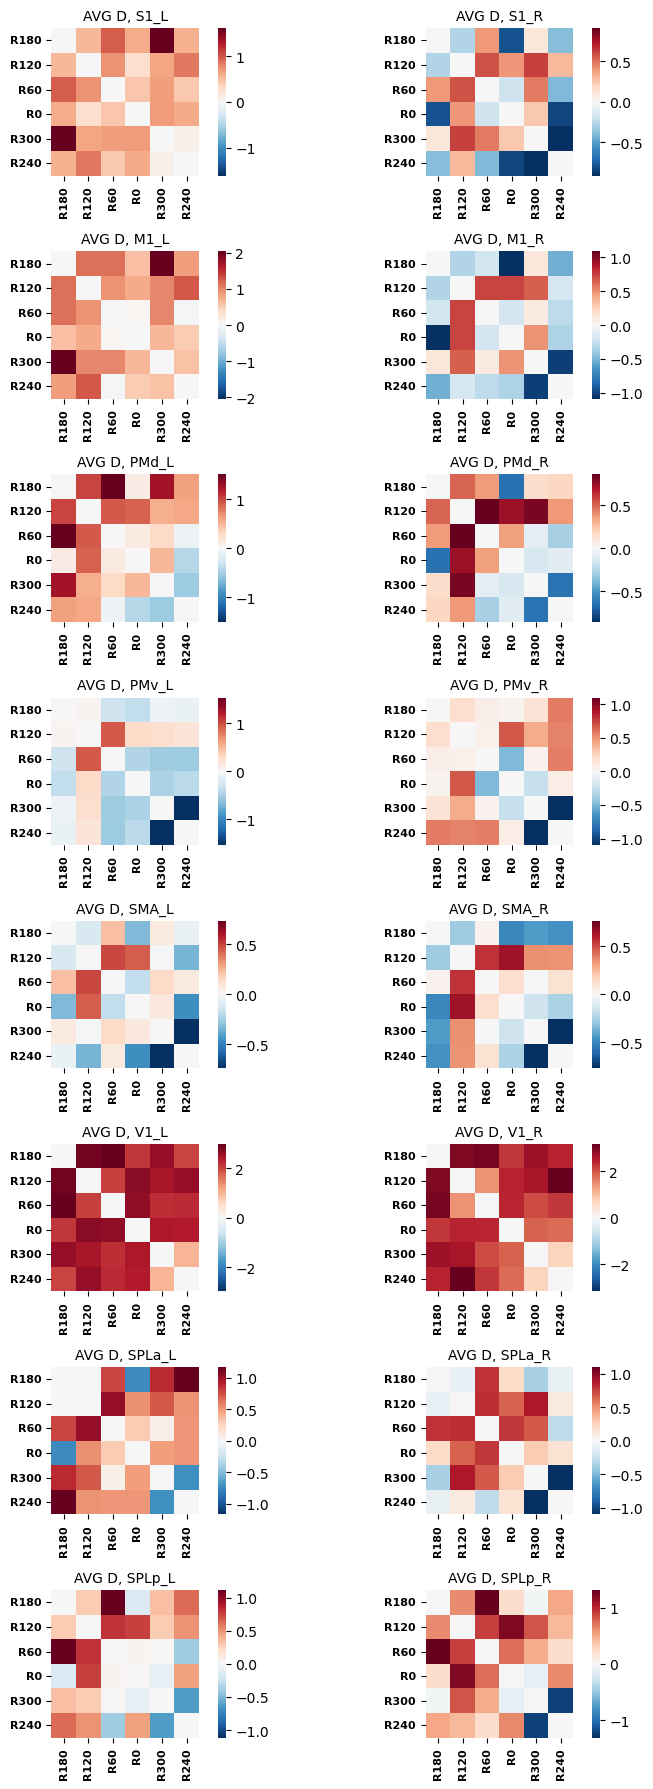

In [ ]:
ana = pd.read_feather(os.path.join(analysisDir,'G_right_uni.feather'))

rdm_cols = ['rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240'] 
labels = ['R180','R120','R60','R0','R300','R240']
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

sn_list = ana.sn.unique()
hem = ana.hem.unique()
regions = ana.region.unique()

D_avg = np.zeros((len(hem),len(regions), len(rdm_cols), len(rdm_cols)))
n_cond = len(rdm_cols)
cmap = matplotlib.cm.RdBu.reversed()
for sn in sn_list:
    fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8,18))
    for j, h in enumerate(hem):
        for i, ax in enumerate(axes[:,j].flat):
            row = ana[(ana.sn==sn) & (ana.hem==h) & (ana.region==region_names[i])]
            D = utils.please.retrieve_matrix(row, prefix='D', colnames=rdm_cols)
            v_max = np.max(D)
            v_min = np.min(D)
            v_max = max(abs(v_max), abs(v_min))
            
            # cmap_reversed = cmap.reversed()
            sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
            ax.set_title(f'D, {region_names[i]}_{h}, s{sn}', fontsize=10)

            # Set labels manually with more formatting options
            ax.set_xticks(np.arange(0,n_cond)+0.5)
            ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
            ax.set_yticks(np.arange(0,n_cond)+0.5)
            ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')

            # avg RDMs:
            D_avg[j,i,:,:] = D_avg[j,i,:,:] + D/len(sn_list)
        
    plt.tight_layout()
    plt.savefig(f'../figures/D_uni_within_hand/s{sn}_right_D.pdf', bbox_inches="tight")
    plt.close()

# AVG D PLOT:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8,18))
for j, h in enumerate(hem):
    for i, ax in enumerate(axes[:,j].flat):
        D = D_avg[j,i,:,:]
        v_max = np.max(D)
        v_min = np.min(D)
        v_max = max(abs(v_max), abs(v_min))
        sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
        ax.set_title(f'AVG D, {region_names[i]}_{h}', fontsize=10)
        
        # Set labels manually with more formatting options
        ax.set_xticks(np.arange(0,n_cond)+0.5)
        ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
        ax.set_yticks(np.arange(0,n_cond)+0.5)
        ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/D_uni_within_hand/D_right_avg.pdf', bbox_inches="tight")
plt.show()



## Estimate only left hand - 6x6

In [11]:
glm = 1
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,102,103,104,106,107,108,109,110,111,112,113,114,115]
hem = ['L','R']
atlas,_ = am.get_atlas('fs32k')

# Intrinsic ordering of the conditions:
rdm_cols = ['lhand:0','lhand:60','lhand:120','lhand:180','lhand:240','lhand:300'] 
G_matrices = {}
D_matrices = {}
for sn in sn_list:
    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
    partitions = regressor_info['run'].values.flatten()
    conds = regressor_info['name'].values.flatten()
    conds = np.array([cond.strip() for cond in np.array(conds)])
    
    for j, h in enumerate(hem):
        # ==========================================
        # DATA EXTRACTION
        # ==========================================
        #  Define atlas map
        white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
        pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
        mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

        # File names for data extraction
        nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', "beta_*.nii")))
        nii_names = nii_names[0:480] # remove the run constant regressors
        resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii')]
        
        beta = []
        resMS = []
        beta_white = []
        for i, r in enumerate(region_labels):
            atlas_tmp = atlas.get_hemisphere(j)
            subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
            amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
            # Compute the voxels in native space
            amap.build()
            
            # This extract all the relevant voxels in native space (use for RSA)
            beta = amap.extract_data_native(nii_names)
            idx_nan = np.isnan(beta).any(axis=0)
            beta = beta[:, ~idx_nan]
            resMS = amap.extract_data_native(resMS_name)
            resMS = resMS[:, ~idx_nan]
            beta_white = beta/np.sqrt(resMS)
            
            # ========================================== 
            # Estimated variance-covariance matrix
            # ==========================================
            # select unimanual conditions:
            idx = [tmp in rdm_cols for tmp in conds]
            Y = beta_white[idx,:]
            cond_vec = conds[idx]
            partition_vec = partitions[idx]
            Z = utils.please.indicator(cond_vec, rdm_cols)
            G_hat,_ = pcm.est_G_crossval(Y,
                                         Z,
                                         partition_vec,
                                         X=pcm.matrix.indicator(partition_vec))
            D = np.sign(pcm.G_to_dist(G_hat)) * np.sqrt(np.abs(pcm.G_to_dist(G_hat)))
            
            key = (sn, h, region_names[i])
            G_matrices[key] = G_hat
            D_matrices[key] = D

# Construct the long DataFrame
rows = []
for key in G_matrices:
    sn, hem, region = key
    G = G_matrices[key]
    D = D_matrices[key]

    row = {'sn': sn, 'hem': hem, 'region': region}
    row.update(utils.please.flatten_matrix(G, rdm_cols, 'G'))
    row.update(utils.please.flatten_matrix(D, rdm_cols, 'D'))
    rows.append(row)

ana = pd.DataFrame(rows)
ana.to_csv(os.path.join(analysisDir,'G_left_uni.csv'), index=False)
ana.to_feather(os.path.join(analysisDir,'G_left_uni.feather'))



### plot D

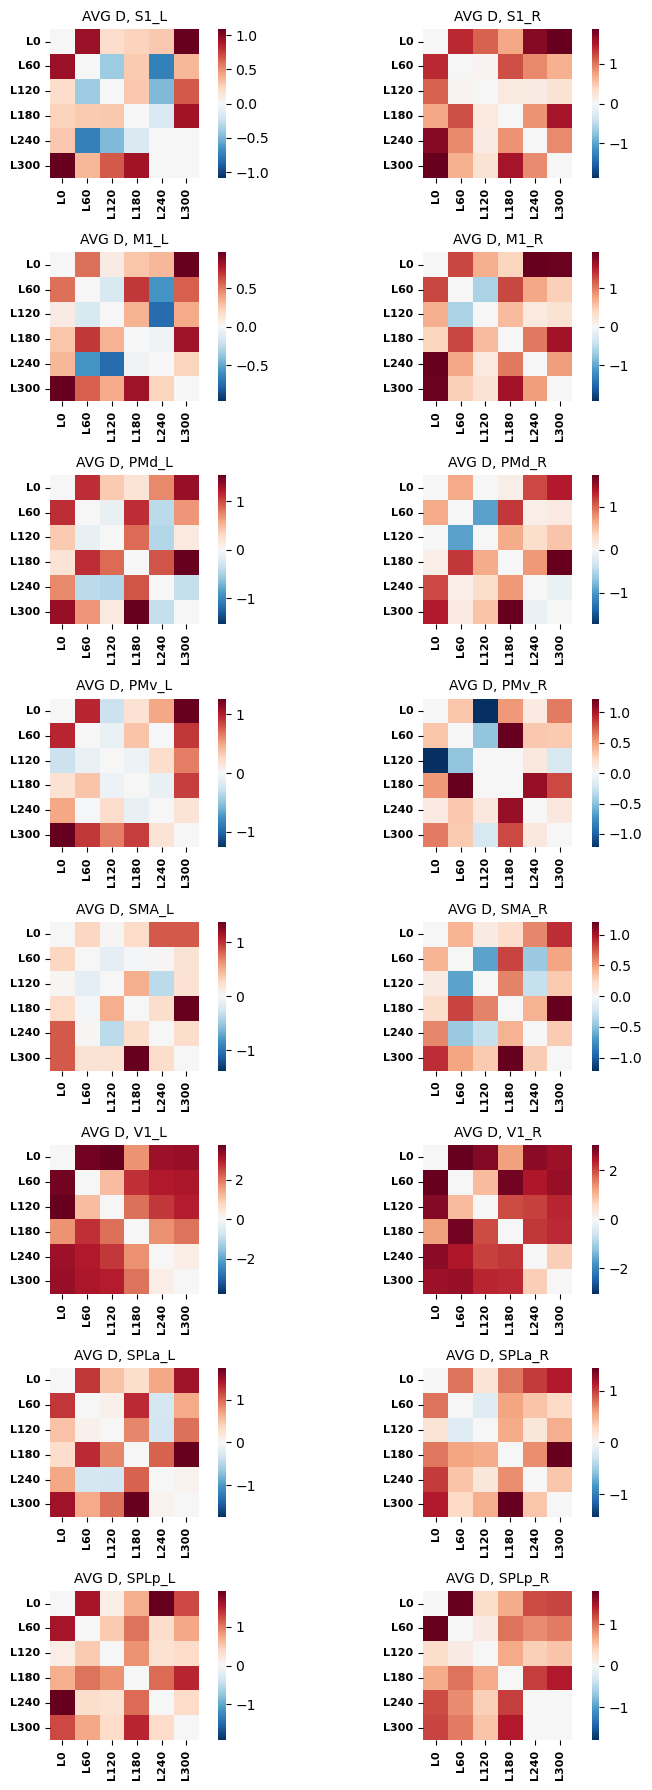

In [10]:
ana = pd.read_feather(os.path.join(analysisDir,'G_left_uni.feather'))

rdm_cols = ['lhand:0','lhand:60','lhand:120','lhand:180','lhand:240','lhand:300'] 
labels = ['L0','L60','L120','L180','L240','L300']
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

sn_list = ana.sn.unique()
hem = ana.hem.unique()
regions = ana.region.unique()

D_avg = np.zeros((len(hem),len(regions), len(rdm_cols), len(rdm_cols)))
n_cond = len(rdm_cols)
cmap = matplotlib.cm.RdBu.reversed()
for sn in sn_list:
    fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8,18))
    for j, h in enumerate(hem):
        for i, ax in enumerate(axes[:,j].flat):
            row = ana[(ana.sn==sn) & (ana.hem==h) & (ana.region==region_names[i])]
            D = utils.please.retrieve_matrix(row, prefix='D', colnames=rdm_cols)
            v_max = np.max(D)
            v_min = np.min(D)
            v_max = max(abs(v_max), abs(v_min))
            
            # cmap_reversed = cmap.reversed()
            sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
            ax.set_title(f'D, {region_names[i]}_{h}, s{sn}', fontsize=10)

            # Set labels manually with more formatting options
            ax.set_xticks(np.arange(0,n_cond)+0.5)
            ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
            ax.set_yticks(np.arange(0,n_cond)+0.5)
            ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')

            # avg RDMs:
            D_avg[j,i,:,:] = D_avg[j,i,:,:] + D/len(sn_list)
        
    plt.tight_layout()
    plt.savefig(f'../figures/D_uni_within_hand/s{sn}_left_D.pdf', bbox_inches="tight")
    plt.close()

# AVG D PLOT:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8,18))
for j, h in enumerate(hem):
    for i, ax in enumerate(axes[:,j].flat):
        D = D_avg[j,i,:,:]
        v_max = np.max(D)
        v_min = np.min(D)
        v_max = max(abs(v_max), abs(v_min))
        sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
        ax.set_title(f'AVG D, {region_names[i]}_{h}', fontsize=10)
        
        # Set labels manually with more formatting options
        ax.set_xticks(np.arange(0,n_cond)+0.5)
        ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
        ax.set_yticks(np.arange(0,n_cond)+0.5)
        ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/D_uni_within_hand/D_left_avg.pdf', bbox_inches="tight")
plt.show()


